# Class Challenge: Image Classification of COVID-19 X-rays
# Task 2 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Multi-class Classification

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# os.environ['OMP_NUM_THREADS'] = '1'
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf.__version__

'2.6.0'

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10053575647669565555
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6252920832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6610614899885848118
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


#### Load Image Data

In [3]:
DATA_LIST = os.listdir('all/train')
DATASET_PATH  = 'all/train'
TEST_DIR =  'all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


C:\Users\Li\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [5]:
from tensorflow.keras.applications import VGG16
from keras.layers.core import Flatten, Dense, Dropout, Lambda


vgg16 = VGG16(weights='imagenet',include_top=False,pooling = "None", classes = 2, input_shape=(224, 224, 3))
vgg16.trainable = False

model = tf.keras.models.Sequential()
model.add(vgg16)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 21,138,500
Trainable params: 6,423,812
Non-trainable params: 14,714,688
_________________________________________________________________


#### [5 points] Train Model

In [6]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

history=model.fit_generator(train_batches, steps_per_epoch =STEP_SIZE_TRAIN, validation_data = valid_batches, validation_steps = STEP_SIZE_VALID, epochs= NUM_EPOCHS)

22
6


C:\Users\Li\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\Li\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Li\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
21/21 [==============================] - 8s 269ms/step - loss: 1.4264 - accuracy: 0.3010 - val_loss: 1.1429 - val_accuracy: 0.4000
Epoch 2/100
21/21 [==============================] - 5s 237ms/step - loss: 1.1732 - accuracy: 0.4563 - val_loss: 1.1100 - val_accuracy: 0.4400
Epoch 3/100
21/21 [==============================] - 5s 230ms/step - loss: 1.1180 - accuracy: 0.4563 - val_loss: 1.1234 - val_accuracy: 0.4600
Epoch 4/100
21/21 [==============================] - 5s 228ms/step - loss: 0.9523 - accuracy: 0.6019 - val_loss: 0.8814 - val_accuracy: 0.6000
Epoch 5/100
21/21 [==============================] - 5s 234ms/step - loss: 0.9605 - accuracy: 0.5680 - val_loss: 0.8906 - val_accuracy: 0.6400
Epoch 6/100
21/21 [==============================] - 5s 236ms/step - loss: 0.8831 - accuracy: 0.6214 - val_loss: 0.9134 - val_accuracy: 0.6000
Epoch 7/100
21/21 [==============================] - 5s 234ms/step - loss: 0.8801 - accuracy: 0.6117 - val_loss: 0.8144 - val_accuracy: 0.6600

#### [5 points] Plot Accuracy and Loss During Training

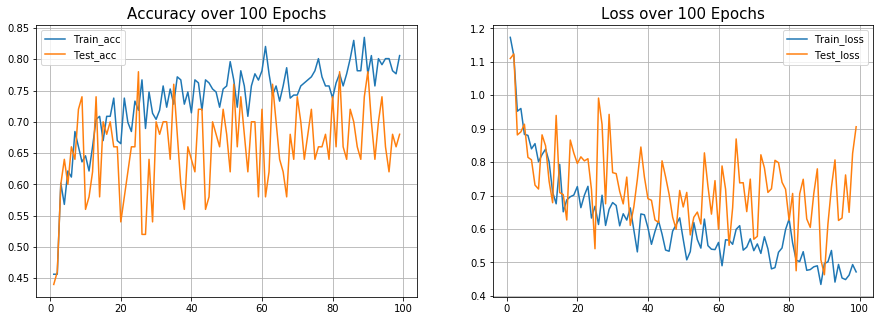

In [7]:
import matplotlib.pyplot as plt

def plot_acc_loss(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.grid(True)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.grid(True)
    plt.legend()
    
    plt.show()

    
plot_acc_loss(history, 100)

#### Testing Model

In [8]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36


C:\Users\Li\anaconda3\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


36/36 [==============================] - 1s 16ms/step - loss: 0.7485 - accuracy: 0.7500
Test loss: 0.748456597328186
Test accuracy: 0.75


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 270 images belonging to 4 classes.
{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}
  1/270 [..............................] - ETA: 29s

C:\Users\Li\anaconda3\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


270/270 [==============================] - 4s 13ms/step


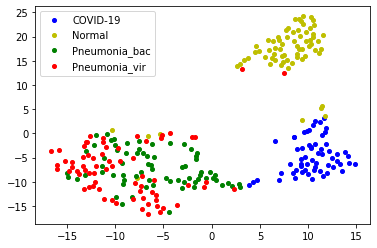

In [11]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense').output)
tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")
print(tsne_eval_generator.class_indices)

outputs = intermediate_layer_model.predict_generator(tsne_eval_generator,270,verbose=1)
features = TSNE(n_components=2).fit_transform(outputs)
label = tsne_eval_generator.classes


covid_x, covid_y, normal_x, normal_y, pneumonia_bac_x, pneumonia_bac_y, pneumonia_vir_x, pneumonia_vir_y = [],[],[],[],[],[],[],[]

plt.figure()
for index in range(len(features)):
    if label[index] == 0:
        covid_x.append(features[index, 0])
        covid_y.append(features[index, 1])        
    elif label[index] == 1:
        normal_x.append(features[index, 0])
        normal_y.append(features[index, 1]) 
    elif label[index] == 2:
        pneumonia_bac_x.append(features[index, 0])
        pneumonia_bac_y.append(features[index, 1]) 
    else:
        pneumonia_vir_x.append(features[index, 0])
        pneumonia_vir_y.append(features[index, 1]) 

plt.plot(covid_x, covid_y,'bo', ms=4, label="COVID-19")
plt.plot(normal_x, normal_y,'yo', ms=4, label="Normal")
plt.plot(pneumonia_bac_x, pneumonia_bac_y, 'go', ms=4, label="Pneumonia_bac")
plt.plot(pneumonia_vir_x, pneumonia_vir_y, 'ro', ms=4, label="Pneumonia_vir")

plt.legend(loc='upper left')

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->